# Satellite derived Image Denoising with Deep CNNs

Use deep Convolutional Neural Networks (CNNs) with PyTorch, including investigating DnCNN and U-net architectures.

## Terminology - classes and architectures

This notebook includes the following Python classes that implement Convolutional Neural Networks (CNNs):
- `DnCNN` - De-noising CNN
- `UDnCNN` - U-shaped De-noising CNN
- `DUDnCNN` - Dilated U-shaped De-noising CNN

## Using forked repository

https://github.com/agstephens/Image-Denoising-with-Deep-CNNs

## Installations

Need to run:

```
!pip install torch torchvision
```

## 1. Get started

In [42]:
%matplotlib inline
#%matplotlib ipympl 

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
import nntools as nt
import time

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2. Creating noisy images of BSDS dataset with DataSet

Our goal is to use deep convolutional neural networks to learn the mapping $x_i$ → $y_i$ where $x_i$ are noisy images (our data/observations) and $y_i$ are clean images (our labels/ground-truth). We will consider the images of the BSDS dataset as our clean/ground-truth images: $y_i$. For each of them, we will generate noisy versions by adding white Gaussian noise: $x_i = y_i + w_i$ where $w_i$ is an image where each pixel is an independent realization of a zero-mean Gaussian distribution with standard deviation `σ = 30`. Since
images have different sizes, we will consider random crops of size of `180 × 180`.

In [44]:
# import zipfile
# zpath = "/neodc/sentinel3a/data/SLSTR/L1_RBT/2023/05/01/S3A_SL_1_RBT____20230501T011522_20230501T011822_20230502T102717_0179_098_188_1980_PS1_O_NT_004.zip"
# zfile = zipfile.ZipFile(zpath)

# def get_s3a_nc(zpath, image_id="S4_radiance_ao"):
#     zfile = zipfile.ZipFile(zpath)
#     zip_object = [z for z in zfile.filelist if z.filename.endswith(f"{image_id}.nc")][0]
#     ncpath = zfile.extract(zip_object)
#     return ncpath

In [45]:
# ncpath = get_s3a_nc(zpath)

# import xarray as xr
# ds = xr.open_dataset(ncpath)
# ds

In [46]:
# dataset_root_dir = '../dataset/BSDS300/images'

# if not os.path.isdir(dataset_root_dir):
#     !cd ../ ; mkdir -p dataset ; 
#     !cd ../dataset/ ; wget BSDS300-images.tgz https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
#     !cd ../dataset/ ; tar xvzf BSDS300-images.tgz ; rm BSDS300-images.tgz
#     print("Dataset downloaded and unpacked.")
# else: 
#     print("Dataset already downloaded.")

In [47]:
# !ls /neodc/sentinel3a/data/SLSTR/L1_RBT/2023/06/01/*__20230601T000037*_004.zip

In [48]:
# /neodc/sentinel3a/data/SLSTR/L1_RBT/2023/06/01/S3A_SL_1_RBT____20230601T000037_20230601T000337_20230601T013550_0179_099_244_3780_PS1_O_NR_004.zip
class NoisySLSTRDataset(td.Dataset):

    def __init__(self, root_dir,
                 mode='train', image_size=(180, 180), sigma=30):
        super(NoisySLSTRDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisySLSTRDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')

        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + (2 / 255) * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [51]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

#### Build training set and testing set

In [52]:
data_root = "/gws/smf/j04/cmip6_prep/users/astephen/ai-sat-test/AI" # "/gws/nopw/j04/cloudcatcher/AI"
train_set = NoisySLSTRDataset(data_root)
test_set = NoisySLSTRDataset(data_root, mode='test', image_size=(320, 320))

image size is torch.Size([3, 320, 320]).


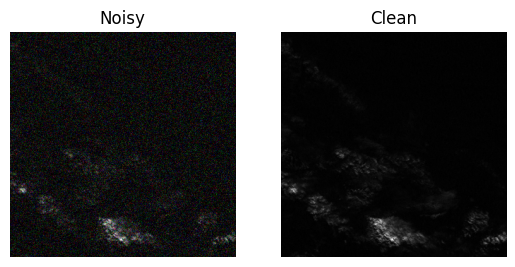

In [53]:
x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

## 3. DnCNN

![](../images/dncnn.png)

#### create a subclass NNRegressor that inherits from NeuralNetwork and implements the method criterion as being the MSE loss.

In [54]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

### Importance of weight initialization

#### without weight initialization

In [55]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

**Note:** In order to preserve the spatial feature dimensions between each successive layer of the network, we will have to use zero-padding by a suitable number of pixels that you have to determine.

In [56]:
torch.cuda.is_available()

True

### !!!CUDA_VISIBLE_DEVICES needed setting for MIG to work - else you get a CUDA error

See [docs](https://docs.nvidia.com/datacenter/tesla/mig-user-guide/index.html#cuda-device-enumeration).

In [57]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.randn(1).cuda()
!nvidia-smi

Wed Nov 13 13:05:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:81:00.0 Off |                   On |
| N/A   28C    P0             79W /  400W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [58]:
train_set[-1][-1].shape

torch.Size([3, 180, 180])

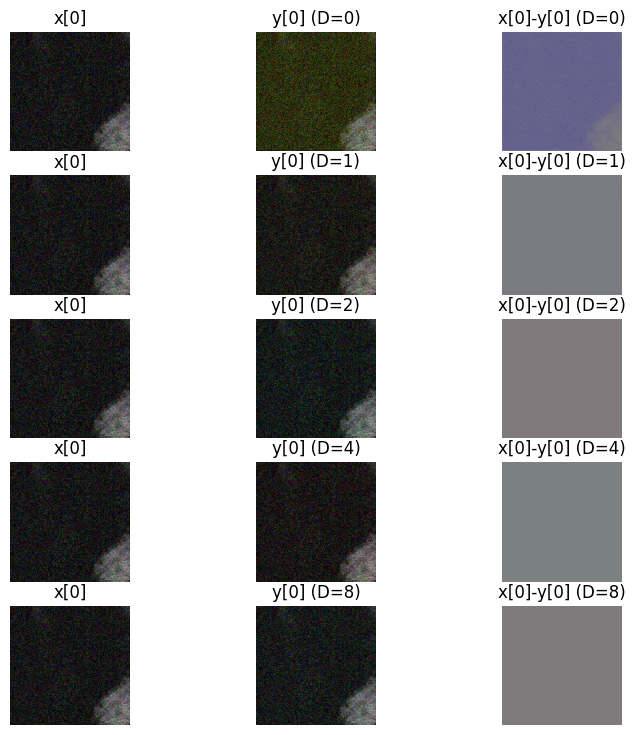

In [59]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x) # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

Except for `DnCNN` with `D=0`, the others have **NO** residuals, showing only gray. It seems that it has gradient vanishment problem. So as the number of layers of a network grows, it is more unlikely for a network to learn. In other words, the output is just like the input, and thus `x[0] - y[0]` is nothing.

As for the implication on backprop, since the output is the same as the input except for `DnCNN` with `D=0`, their gradient and weight update are the same as well, which means the network cannot learn well.

#### with weight initialization

In [60]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

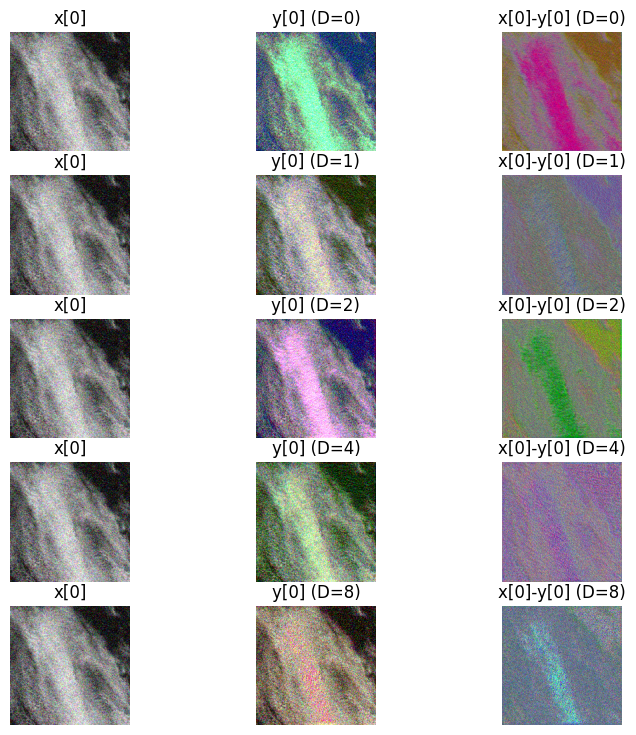

In [61]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

`DnCNN` with all different `D` have residual with non-zero values now. This is because He's initialization activates half of the neurons which avoid vanishing gradient in the ReLU. Now, since the output is different from the input, the gradient and weight update are different, enabling the network to learn properly.

### Peak Signal-to-Noise-Ratio (PSNR)

A very classical (but controversial) way to compare the quality of restoration techniques is to use the PSNR (Peak Signal-to-Noise-Ratio) defined for images ranging in `[−1, 1]` as
$$
PSNR = 10\log_{10}\frac{4n}{\Vert y-d\Vert_2^2}
$$

where $d$ is the desired ideal image, $y$ is the estimate obtained from $x$ and $n$ the number of elements in the tensor. The PSNR measures in decibels (dB) the quality of the restoration: the higher the better.

### Create the sub-class `DenoisingStatsManager` that inherits from `StatsManager` and computes and averages PSNR between mini-batches

In [62]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10 * torch.log10(4*n / (torch.norm(y - d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [63]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')

#    import pdb; pdb.set_trace()
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'].cpu() for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

### train the `DnCNN`

In [64]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4,
               output_dir="../checkpoints/DnCNN_sentinel", perform_validation_during_training=True)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[10][0]))

Start/Continue training from epoch 0
Epoch 1 | Time: 41.61s | Training Loss: 0.028138 | Evaluation Loss: 0.014424
Epoch 2 | Time: 38.60s | Training Loss: 0.013632 | Evaluation Loss: 0.009984


## Recap about the dataset

The input dataset only contains clean images. However, the `Noisy*Dataset` classes generates a noisy image (by adding some random noise) and returns `X, y` values of:
1. Input image (noisy)
2. Output image (clean)

In [ ]:
# a, b = test_set[1]
# a, b = a.numpy().transpose([1, 2, 0]), b.numpy().transpose([1, 2, 0])
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(a)
# ax[1].imshow(b)

### Performance evaluation

In [ ]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[12]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

There are some areas that lost information. Besides, although the denoise image looks great, based on the PSNR, we can know that noise still exists.

## Test the DnCNN on some satellite data examples

In [ ]:
#sat_train_set = NoisySatelliteDataset(sat_dir)
sat_test_set = NoisySLSTRDataset(data_root, mode='test', image_size=(320, 320))
fig, axes = plt.subplots(ncols=2, figsize=(9,5), sharex='all', sharey='all')

titles = "half-n-half", "clean"
img = sat_test_set[1]
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

In [ ]:
def test_model_with_data(model, test_set, limit=5):
    for n in range(min(len(test_set), limit)):     
        img = []
        titles = ['original', 'modified', 'model output', 'model output - clean']
        
        x, clean = test_set[n]
        x = x.unsqueeze(0).to(device)
        img.append(clean)
        img.append(x[0])
        
        model.eval()
        with torch.no_grad():
            y = model.forward(x)

        img.append(y[0])
        img.append(y[0] - clean.to(device))
            
        fig, axes = plt.subplots(ncols=4, figsize=(13, 5), sharex='all', sharey='all')

        for i in range(len(img)):
            myimshow(img[i], ax=axes[i])
            axes[i].set_title(f'{titles[i]}')

In [ ]:
test_model_with_data(exp1.net.to(device), sat_test_set)

### parameters of `DnCNN`

In [ ]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

### Number of parameters:

The first layer has `64 x 3 x 3 x 3` parameters. The middle `D` layers have `64 x 64 x 3 x 3 x D` parameters. The last layer has `3 x 64 x 3 x 3` parameters. Hence, there are total `3456 + 36864 x D` parameters.

### Receptive field

Based on the equation to compute the receptive field $2^{k-l+1}\times padding\ size$ where `k` and `l` are the number of the pooling and unpooling layers respectively, we can know that since there are no pooling and unpooling layers, each layer increase the width and height of receptive field by $2^{0-0+1}=2$. Besides, the receptive field of the input layer is `1`. We can infer that the receptive field of `DnCNN(D)` is $(1+2\times (D+2))^2$. Take `D=6` for example, the receptive field is $17^2$.

### Testing the literature statements

The Denoising literature claims that for reducing Gaussian noise of standard deviation $σ = 30$ efficiently, a pixel should be influenced by at least $33 × 33$ pixels. How large $D$ (how deep) should DnCNN be to satisfy this constraint?

Since receptive field is $(1+2\times (D+2)) \times (1+2\times (D+2))$, we can infer that $1+2\times (D+2) = 33$ and obtain $D=14$. For the number of parameters, it would be $3456 + 36864 \times 14 = 519,552$. Besides, we can infer that as the number of parameters increases, the computation time would increase as well.

## 4. U-net like CNNs

![](../images/udncnn.png)

In [ ]:
class UDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool2d(F.relu(self.bn[i](self.conv[i+1](h))), 
                                  kernel_size=(2,2), return_indices=True)
            h_buff.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        for i in range(D//2+1, D):
            j = i - (D//2 + 1) + 1
            h = F.max_unpool2d(F.relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=(2,2), output_size=shape_buff[-j])
        y = self.conv[D+1](h) + x
        return y

### train the `UDnCNN`

In [ ]:
lr = 1e-3
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/UDnCNN_sentinel", perform_validation_during_training=True)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[10][0]))

### parameters of `UDnCNN`

In [ ]:
for name, param in exp2.net.named_parameters():
    print(name, param.size(), param.requires_grad)

Since pooling and unppooling do not have learnable parameters, the number of parameters of `UDnCNN` is the same as that of `DnCNN`, which is `3,456 + 36,864 x D`.

The receptive field of `UDnCNN` would be $(1+\sum_{i=1}^{D/2}2^i+2\times 2^{D/2}+\sum_{i=1}^{D/2-1}2^i+2)^2$. For the case `D=6`, the receptive field would be $(1+(2+4+8)+(2\times 8)+(4+2)+2)^2=39^2$.

I do not believe `UDnCNN` would beat `DnCNN` because `UDnCNN` uses pooling which might lose some information. Based on the training PSNR, `UDnCNN` indeed is a bit worse than `DnCNN`.

### Performace comparison between `DnCNN` and `UDnCNN`

In [ ]:
# DnCNN
exp1.evaluate()

In [ ]:
# UDnCNN
exp2.evaluate()

## 5. U-net like CNNs with dilated convolutions

Though pooling layers increase the receptive field, they lose information about exact locations. This is desired for classification, but for denoising this decreases performance. An alternative to pooling is to use dilated convolutions (sometimes refer to the à trous algorithm, meaning with holes). Instead of increasing the receptive field by reducing the feature spatial dimensions by a factor 2 after each convolution, the filters are dilated by a factor 2. In order to maintain the same number of parameters, the dimensions are increased by injecting “holes” between each rows and columns of the filter. Please, refer to the following figure:

![](../images/dilated_conv.png)

In theory, dilated convolutions should not be slower than standard convolutions, but for some reasons there are when using the default PyTorch backend implementation. For this reason, add the two instructions `torch.backends.cudnn.benchmark=True` and `torch.backends.cudnn.benchmark=False`, before and after running any dilated convolutions. For more details, see the discussion here: [https://github.com/pytorch/pytorch/issues/15054](https://github.com/pytorch/pytorch/issues/15054).

In [ ]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

### train the `DUDnCNN`

In [ ]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/DUDnCNN_sentinel", perform_validation_during_training=True)

In [ ]:
exp3

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[10][0]))

### Performance comparison among `DnCNN`, `UDnCNN`, and `DUDnCNN`

In [ ]:
# DnCNN
exp1.evaluate()

In [ ]:
# UDnCNN
exp2.evaluate()

In [ ]:
# DUDnCNN
exp3.evaluate()

In [ ]:
num = 3
img = []
nets = [exp1.net, exp2.net, exp3.net]
titles = ['DnCNN', 'UDnCNN', 'DUDnCNN']

for i in range(num):
    x, _ = test_set[7*i+7]
    x = x.unsqueeze(0).to(device)
    img.append(x)

fig, axes = plt.subplots(nrows=num, ncols=3, figsize=(9,6), sharex='all', sharey='all')
for i in range(num):
    for j in range(len(nets)):
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(img[i])

        myimshow(y[0], ax=axes[i][j])
        axes[i][j].set_title(f'{titles[j]}')

### parameters of `DUDnCNN`

In [ ]:
exp3.net

In [ ]:
for name, param in exp3.net.named_parameters():
    print(name, param.size(), param.requires_grad)

* number of parameters:  
The number of parameters of `DUDnCNN` is the same as that of `UDnCNN` and `DnCNN` because dilated convolution does not have extra parameters, compared with original convolution. So, the number of parameters of `DUDnCNN(D)` is `3456 + 36864 x D`

* receptive field:  
Since the padding size is not the same for each layer as the `UDnCNN`, the receptive field for `DUDnCNN` is $(1+2+\sum_{i=1}^{D/2}2^i\times 2^{i-1}+2^{D/2}\times 2^{D/2-1}+\sum_{i=1}^{D/2-1}2^i\times 2^{i-1}+2)^2$. For `DUDnCNN(6)`, its receptive field is $89^2$. **Not sure for this**

# Let's try out all 3 models with our example data

In [ ]:
# Model 1: DnCNN
test_model_with_data(exp1.net.to(device), sat_test_set)

In [ ]:
# Model 2: UDnCNN
test_model_with_data(exp2.net.to(device), sat_test_set)

In [ ]:
# Model 3: DUDnCNN
test_model_with_data(exp3.net.to(device), sat_test_set)